(c) Juan Gomez 2019. Thanks to Universidad EAFIT for support. This material is part of the course Introduction to Finite Element Analysis

# Application: Visualization in a Full Domain

## Introduction

This Notebook formalizes the concept of **finite element** as a canonical interpolation domain. For that purpose we use as example, the interpolation ideas discussed so far in the visualization of a function over a two-dimensional space. We first introduce an empriric definition of a **mesh** as a discretization of the computational space into many non-overlapping quadrilaterals or **finite elements**. To perform the visualization the selected (arbitrary) function will be evaluated at the nodal points of each element. These resulting nodal values would later be used to conduct interpolation one element at a time. The nodal values, together with the mesh information (coordinates of the nodal points and relevant element data), are then passed into a set of plotting subroutines based on interpolation. We will not take care of the interpolation ourselves but instead will use Python's own libraries.

The notebook covers then the first approximation to meshes and its representation into elements and nodal arrays. Here we will use a mesh that has been previously created and is available in memory and is given in terms of text files. **After completing this notebook you should be able to:**

* Identify a finite element as a general interpolation space.

* Recognize the concept of a mesh and its representation in terms of nodal and elemental data.

* Use Python's Triangulation objects as a tool to perform interpolation operations.

* Apply SolidsPy post-processing subroutines in the visualiazation of functions.


## Finite element discretization of a two-dimensional domain
The figure below shows a square domain which has been discretized (or covered) by a number of non-overlapping quadrilateral elements. These elements are analogous to the single quadrilateral domains covered in previous notebooks.


<center><img src="img/mydomain.png" alt="mesh" style="width:600px"></center>

The **mesh** or set of **finite elements** is defined by 2 basic geometric entities namely, the **nodal points** and the **elements**.The relavant data for a nodal point is defined by a nodal identifier (usually an integer) and by its corresponding space coordinates. Similarly an element is defined by and ordered arrangement of 4-nodal points, called the element **connectivities**. The order of the nodal points defining an element must be consistent with the pre-defined order of the shape functions in the canonical element. In summary a mesh is defined by the identifiers and spatial coordinates of all the nodal points and by the connectivities of all the elements coverig the computational domain.

A common way to pass a mesh into a finite element program is through text files. In the current example the mesh is represented by two text files (**Vnodes.txt** and **Veles.txt** available in the **files** folder of the Repo) which contain the nodal point coordinates and the list of nodal connectivities conforming each element. The figure below shows the typical structure of text files used in finite element codes. The file on the left is a **nodes** file where the first column contains the nodal identifier defined by an integer, while columns 2 and 3 contain the spatial coordinates for each node. The file on the right is an **elements** file. The first column contains an integer with the element identifier; columns 2 and 3 store parameters (not relevant in this example) and columnss 4 to 7 contain integer numbers defining the nodal connectivities for the specific element. At this point we won't focus in how to create these specific text files but will assume that they reside in memory.

**Questions:**

**Write a Python script that reads files like the ones shown in the figure and stores the data in numpy arrays**

<center><img src="img/textfiles.png" alt="files" style="width:600px"></center>

## Visualization of a function in the two-dimensonal domain.
Using a mesh like the one described above we want to use computational tools based on two-dimensional interpolation theory to visualize the scalar function:

$$f(x,y) = (x^2 + y^2)^p$$

over a rectangular domain. For that purpose we will develop the following steps:

* Create the mesh or set of nodal points arranged into non-overlapping quadrilateral finite elements.

* Evaluate the function in each nodal point of the mesh.

* Using the nodal values of the function interpolate over each element to obtain the solutions at a set of points scattered throughout the element.

* Visualize the solution over the full domain.


The resulting Python code will be composed by a main program and a set of subroutines used to perform the interpolation at the element level and to visualize the solution over the complete doamin.

#### Function defintion

In this initial block of code we import required modules and define the function to be visualized corresponding to:

$$f(x,y) = (x^2 + y^2)^p$$

where $p$ is a parameter.

**Try running the code with different functions**

In [1]:
%matplotlib inline        
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation, CubicTriInterpolator
import numpy as np
import sympy as sym
#
def myfunction(x, y, p):
    ux=(x**2.+y**2.)**p
    return ux

#### Interpolation and visualization subroutines
For the visualization per se we will use subroutines extracted from the post-processing modules in the finite element code [SolidsPY](https://github.com/AppliedMechanics-EAFIT/SolidsPy). These subroutines use a Python [Triangulation object](https://matplotlib.org/api/tri_api.html) where each quadrilateral element is divided into triangles. Python takes each triangle, together with the nodal values of the variables and conducts local interpolation.

The first subrouine from the postprocessing module (called **plot_SFIELD()**) receives as inputs the solution array **UC** storing the value of the function at each nodal point in the mesh; the mesh (defined in terms of the arrays **nodes** and **elements**) and additional plotting paramters. This subroutine calls a second subroutine called **mesh2tri()** which divides each square into triangles as described next.

**Questions:**

**(i) Document the following subroutine by adding a definition of each input and output parameter indicating the type of data in each case and the definition of the parameter within the current context. Follow the example included for the case of UC.**

**(ii) Indicate how the plot_SFIELD() needs to be modified in order to plot a vecrtor field.**

In [2]:
def plot_SFIELD(UC, nodes, elements, Ngra, plt_type="contourf",  levels=12,
               savefigs=False, title="Solution:"  ):
    """Plots a user defined scalar field using a triangulation.
    Parameters
    ----------
    UC : ndarray (float)
      Array with the nodal solution.

    """
    tri = mesh2tri(nodes, elements)
    tri_plot(tri, UC , Ngra , title=r'$U_{var}$',
             figtitle=title + "User variable",
             levels=levels, plt_type=plt_type, savefigs=savefigs,
             filename="uservar.pdf")

Subroutine **mesh2tri()** takes as input parameters the arrays **nodes** and **elements** and use them to convert the finite element mesh into Triangulation objects, which are represented here by the list **tri**. The figure below displays a quad element conformed by 4 nodal points, namely $4 , 5, 6, 2$. Subroutine **mesh2tri()** splits the quad element into two triangles with 3 nodal points $6, 2 , 4$ and $4, 5, 6$. Details about triangular grids in matplotlib can be found [here](https://matplotlib.org/api/tri_api.html).



<center><img src="img/Triangular.png" alt="triangle" style="width:600px"></center>

All the resulting triangles are stored in the list **triangs** which is later passed in to the Pyhton function **Triangulation()** together with the complete list of nodal coordinates.

In [3]:
def mesh2tri(nodes, elements):
    """Generates a matplotlib.tri.Triangulation object from the mesh

    Parameters
    ----------
    nodes : ndarray (float)
      Array with number and nodes coordinates:
        `number coordX coordY BCX BCY`
    elements : ndarray (int)
      Array with the node number for the nodes that correspond to each
      element.

    Returns
    -------
    tri : Triangulation
        An unstructured triangular grid consisting of npoints points
        and ntri triangles.

    """
    x = nodes[:, 1]
    y = nodes[:, 2]
    triangs = []
    for el in elements:
        if el[1]==3:
            triangs.append(el[[3, 4, 5]])
            triangs.append(el[[5, 6, 3]])
        if el[1]==9:
            triangs.append(el[[3, 6, 8]])
            triangs.append(el[[6, 7, 8]])
            triangs.append(el[[6, 4, 7]])
            triangs.append(el[[7, 5, 8]])
        if el[1]==2:
            triangs.append(el[3:])

    tri = Triangulation(x, y, np.array(triangs))
#
    return tri

Once the triangulization has been performed the resulting object, labeled **tri**, is passed to the plotting function (**tri_plot**) together with the solution vector, to perform the final visualization operation.

**Questions:**

**Document the following subroutine by adding a definition of each input and output parameter indicating the type of data in each case and the definition of the parameter within the current context.**

In [4]:
def tri_plot(tri, field, Ngra ,  title="", figtitle="", levels=12, savefigs=False,
             plt_type="contourf" , filename="solution_plot.pdf"  ):

    plt.figure(Ngra)
    if plt_type=="pcolor":
        disp_plot = plt.tripcolor
    elif plt_type=="contourf":
        disp_plot = plt.tricontourf
    plt.figure(figtitle)
    disp_plot(tri, field, levels, shading="gouraud")
    plt.title(title)
    plt.colorbar(orientation='vertical')
    plt.axis("image")
    plt.grid()

#### Main program: mesh reading and function evaluation

We now read the mesh which is stored in the text files **Vnodes.txt** and **Veles.txt** avaialable in the **files** folder of this Repo. The numpy function **loadtxt** reads the text files and convert them into arrays **nodes** and **elements** respectively.

In [5]:
nodes        = np.loadtxt('files/'+'Vnodes.txt')
elements     = np.loadtxt('files/'+'Veles.txt')
nn =len(nodes[:,0])

The main code follows with the extraction of the nodal coordinates from the primary **nodes** array and the initialization of the solution array **SOL[]**.

In [6]:
coords=np.zeros([nn,2])
coords[:,0]=nodes[:,1]
coords[:,1]=nodes[:,2]
SOL = np.zeros([nn])

Now evaluate the solution at each point of coordinates $(x , y)$ and store the result in **SOL[]**.

**Try different values of the power parameter $p$**

In [7]:
par1 = 2.0
for i in range(0,nn):
    x = coords[i,0]
    y = coords[i,1]
    uu =myfunction(x,y,par1)
    SOL[i] = uu

In the final step **SOL[]** is passed to **plot_SFIELD()** to conduct the final visualization operation as discussed above.

C:\Users\AX201 GMRS\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'shading'
  # Remove the CWD from sys.path while we load stuff.


<Figure size 432x288 with 0 Axes>

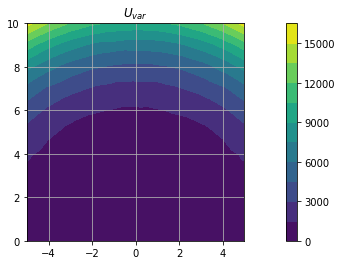

In [8]:
plot_SFIELD(SOL , nodes , elements, 0 , plt_type ="contourf", levels = 12 )

### Glossary of terms.

**Finite element:** Interpolation space of predefined geometry and its associated interpolation functions.

**Element connectivities:** Ordered list of integers identifying nodal points conforming a given finite element.

**Finite element mesh:** A finite number of non-overlapping finite elements covering a complete computational domain.

**SolidsPy:** Finite element solver for the stress analysis of two-dimensional arbitrary domains written in Python.

### Class activity
Consider the theory of elasticity solution for a cantilever beam of height $h = 2c$, length $2\ell$ and moment of inertia $I$, subjected to a uniformly distributed load of intensity $q$ (Timoshenko and Goodier, 2011):

$$\sigma_{xx}=-\frac q{2I}\left(x^2y-\frac23y^3\right)$$

$$\sigma_{yy}=-\frac q{2I}\left(\frac13y^3-c^2y+\frac23c^3\right)$$

$$\tau_{xy}=-\frac q{2I}\left(c^2-y^2\right)x$$



<center><img src="img/beam.png" alt="beam" style="width:600px"></center>


* Identify the problem domain  and use the free three-dimensional mesh generator [Gmsh](http://gmsh.info/) to create a finite element mesh of this domain.

* Use the Python module [meshio](https://github.com/nschloe/meshio) to read the mesh from the **.msh** created file and convert it into the appropriate text files for nodes and elements.

* Use the interpolation and visualization subroutines discussed in the notebook to create an independent script (or notebook) and visualize the principal stresses over the computational domain.

The attached video (in spanish) shows simple steps in the creation and reading of a model combining  [Gmsh](http://gmsh.info/) and [meshio](https://github.com/nschloe/meshio).

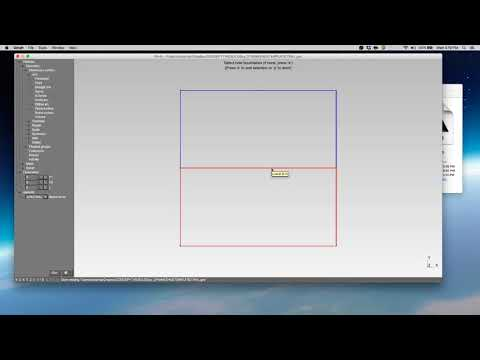

In [9]:
from IPython.display import YouTubeVideo
YouTubeVideo('ibeIKaSYG2U')

### References

* Juan Gómez, Nicolás Guarín-Zapata (2018). SolidsPy: 2D-Finite Element Analysis with Python, <https://github.com/AppliedMechanics-EAFIT/SolidsPy>.

* Timoshenko, S.P., and Goodier, J.N. (1976). Theory of Elasticity. International Student Edition. McGraw-Hill International.

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./nb_style.css', 'r').read()
    return HTML(styles)
css_styling()